In [4]:
#here we test all the components.

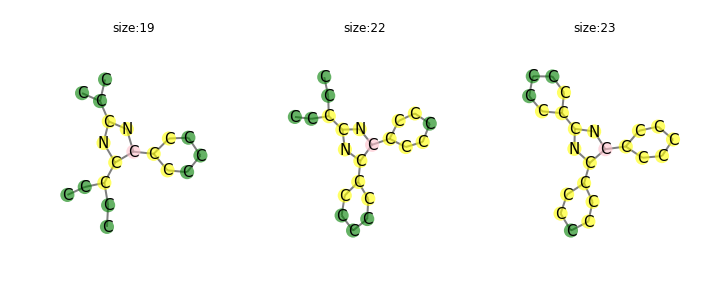

{'core': True, 'hlabel': [771267], 'weight': 1, 'label': 'C'}
{'root': True, 'hlabel': [771267], 'weight': 1, 'label': 'C'}
{'core': True, 'hlabel': [771267], 'weight': 1, 'label': 'C'}
{'core': True, 'hlabel': [537936], 'weight': 1, 'label': 'N'}
{'core': True, 'hlabel': [771267], 'weight': 1, 'label': 'C'}
{'core': True, 'hlabel': [537936], 'weight': 1, 'label': 'N'}
{'interface': True, 'hlabel': [771267], 'weight': 1, 'label': 'C'}
{'interface': True, 'hlabel': [771267], 'weight': 1, 'label': 'C'}
{'core': True, 'hlabel': [771267], 'weight': 1, 'label': 'C'}
{'core': True, 'hlabel': [771267], 'weight': 1, 'label': 'C'}
{'core': True, 'hlabel': [771267], 'weight': 1, 'label': 'C'}
{'interface': True, 'hlabel': [771267], 'weight': 1, 'label': 'C'}
{'interface': True, 'hlabel': [771267], 'weight': 1, 'label': 'C'}
{'interface': True, 'hlabel': [771267], 'weight': 1, 'label': 'C'}
{'interface': True, 'hlabel': [771267], 'weight': 1, 'label': 'C'}
{'interface': True, 'hlabel': [771267], 

In [1]:

'''
first we test the core/interface extractor, since it is most essential
'''
import sys
sys.path.append('..')
%matplotlib inline
from eden.converter.graph.gspan import gspan_to_eden
import graphlearn.utils.draw as myutils
import graphlearn.utils.myeden as myed
import eden.graph as eg
import graphlearn.graphlearn as gl


#get a graph
gr = gspan_to_eden( 'bursi.pos.gspan' )
g=gr.next()


#lets see..
a=gl.extract_core_and_interface(1,g,radius_list=[2,3,4],thickness_list=[2],vectorizer=myed.GraphLearnVectorizer())
ng=myutils.cip_to_graph(a) 
myutils.draw_many_graphs(ng)


for n,d in a[0].graph.nodes(data=True):
    print d

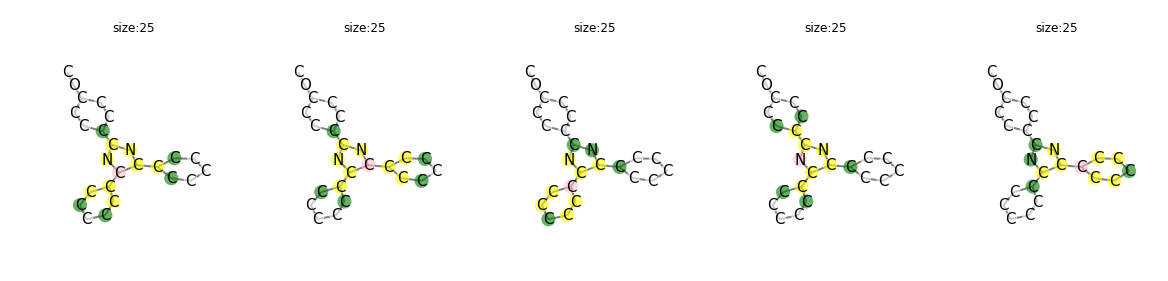

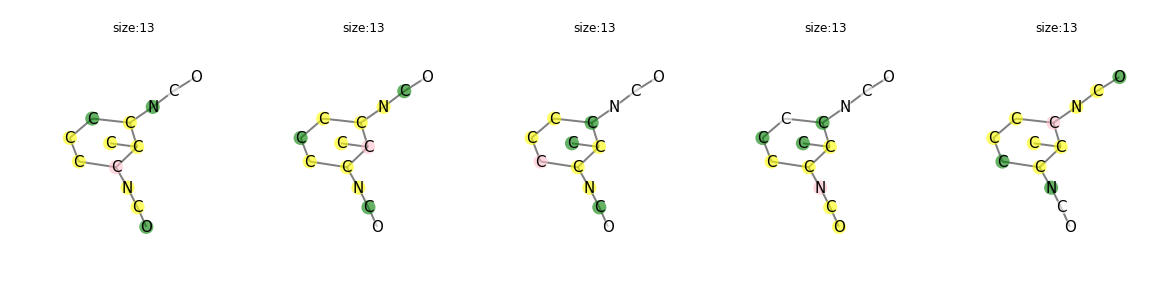

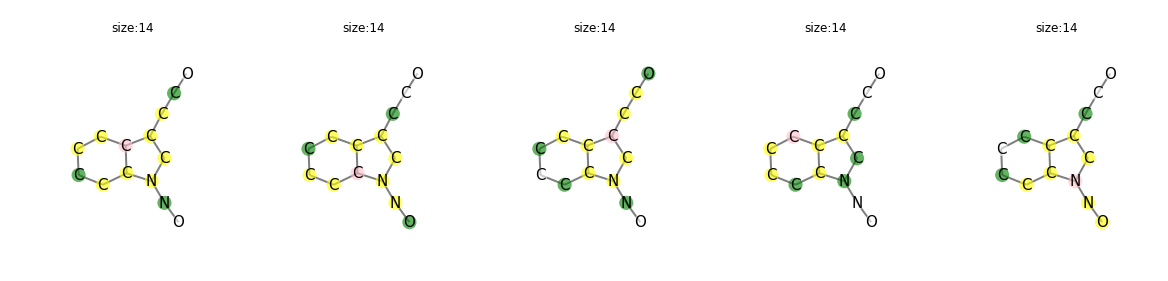

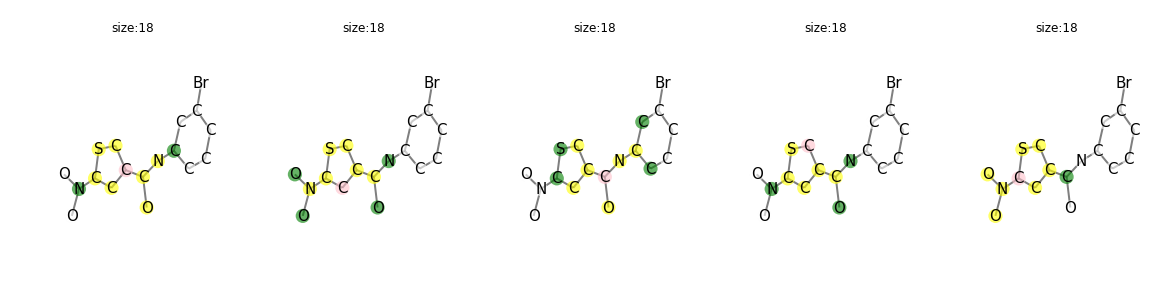

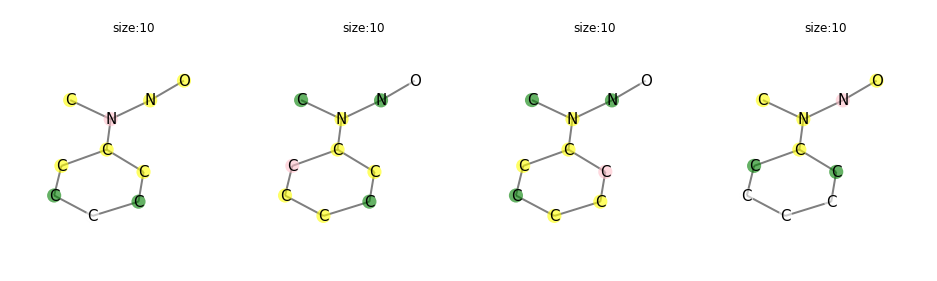

In [11]:
'''
demonstrating more extract core
'''
%matplotlib inline
import sys
sys.path.append('..')
from eden.converter.graph.gspan import gspan_to_eden
import graphlearn.utils.draw as myutils
import graphlearn.utils.myeden as myed
import eden.graph as eg
import graphlearn.graphlearn as gl


#get a graph
gr = gspan_to_eden( 'bursi.pos.gspan' )
for x in range (5):
    g=gr.next()
    nice_graphs=[]
    for n in range(5):
        node=n
        a=gl.extract_core_and_interface(node,g,radius_list=[3],thickness_list=[1],vectorizer=myed.GraphLearnVectorizer())
        nice_graphs+=myutils.cip_to_graph(a, graphs=[g,g]) 
    myutils.draw_many_graphs(nice_graphs)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.000230573785162, average=False, class_weight=None,
       epsilon=0.1, eta0=0.699867007802, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='hinge', n_iter=22, n_jobs=1,
       penalty='l1', power_t=0.884794490279, random_state=None,
       shuffle=True, verbose=0, warm_start=False),
            cv=3, method='sigmoid')
interface: 524368


/usr/local/lib/python2.7/dist-packages/sklearn/calibration.py:398: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/usr/local/lib/python2.7/dist-packages/sklearn/calibration.py:408: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/usr/local/lib/python2.7/dist-packages/sklearn/calibration.py:410: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)


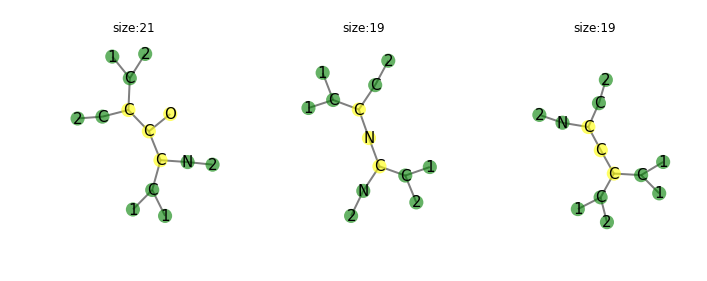

interface: 786592


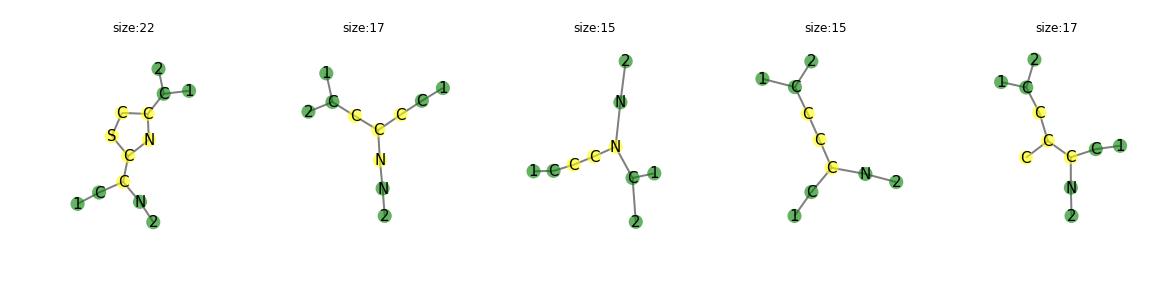

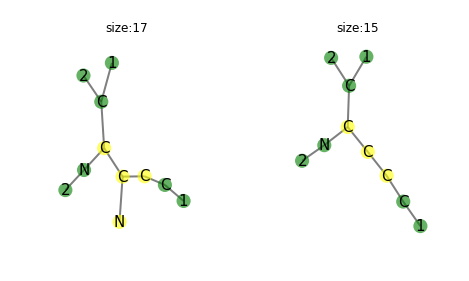

interface: 177


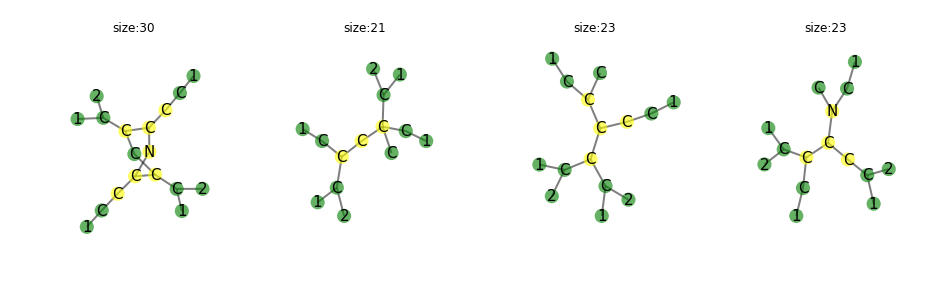

interface: 622834


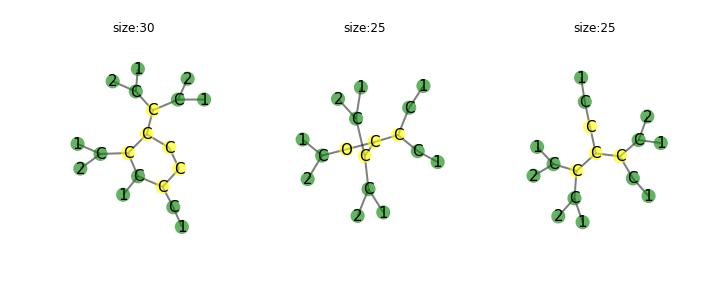

interface: 459004


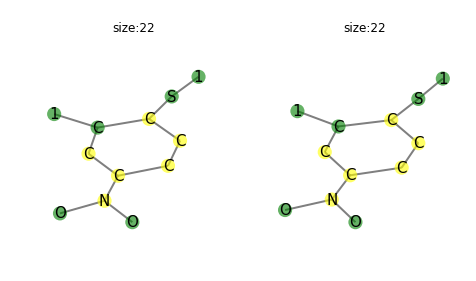

CPU times: user 1min 52s, sys: 13.3 s, total: 2min 5s
Wall time: 5min 2s


In [1]:
%%time
'''
second is reading a grammar and training an estimator
'''
import sys
sys.path.append('..')
import os 
os.nice(20)
%matplotlib inline
import graphlearn.utils.draw as myutils
import graphlearn.graphlearn as gl
from eden.converter.graph.gspan import gspan_to_eden
import itertools
gr = gspan_to_eden( 'bursi.pos.gspan' )
radius_list=[3,5]
thickness_list=[2]
#gr = itertools.islice(gr,50)

sampler=gl.GraphLearnSampler(radius_list,thickness_list)
#sampler=sampler.load('tmp/demo.ge')
sampler.fit(gr,n_jobs=4)
print sampler.estimator
sampler.save('tmp/demo.ge')
myutils.draw_grammar(sampler.local_substitutable_graph_grammar.grammar,5)

loading done


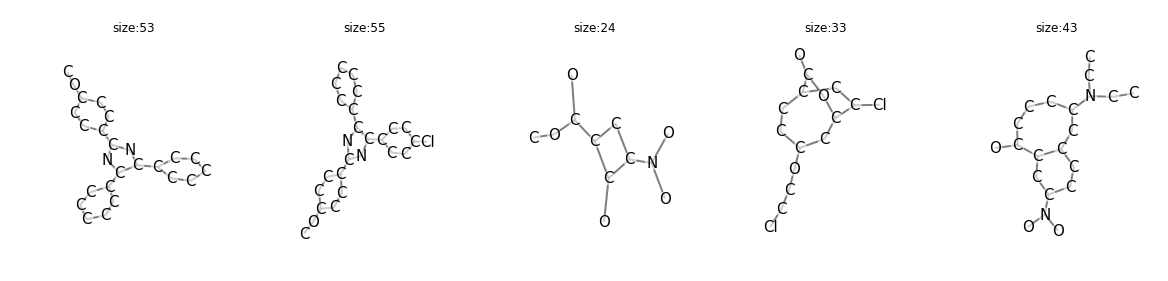

DEBUG:log:graph non existent


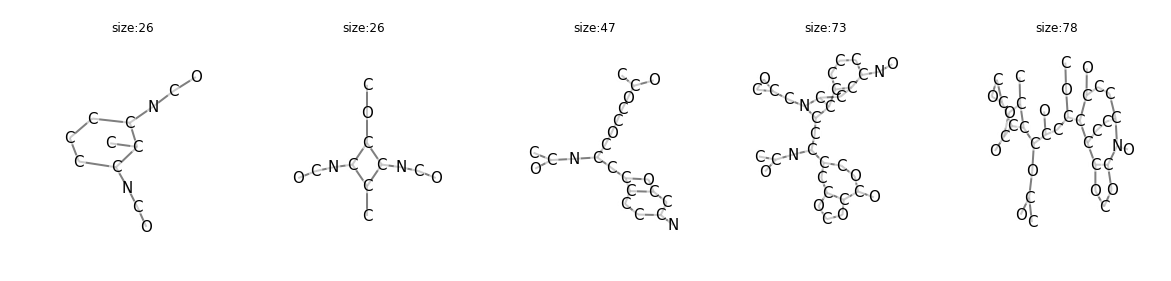

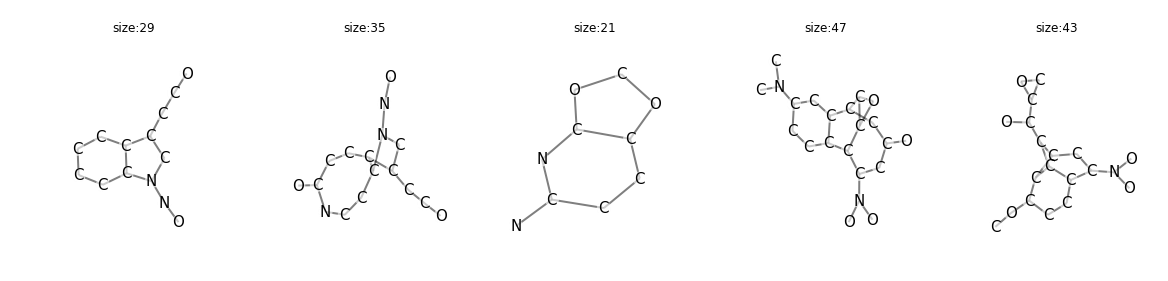

DEBUG:log:graph non existent
DEBUG:log:graph non existent
select_cips_from_grammar didn't find any acceptable cip; entries_found 2
INFO:log:select_cips_from_grammar didn't find any acceptable cip; entries_found 2


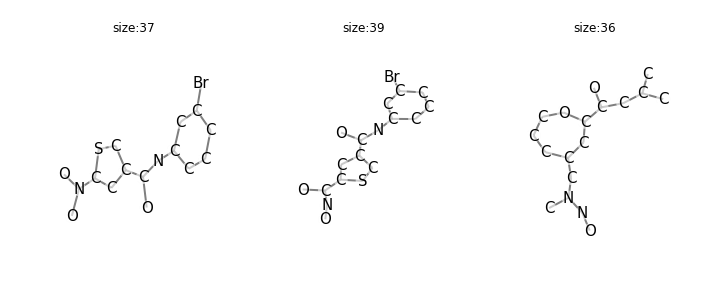

DEBUG:log:graph non existent


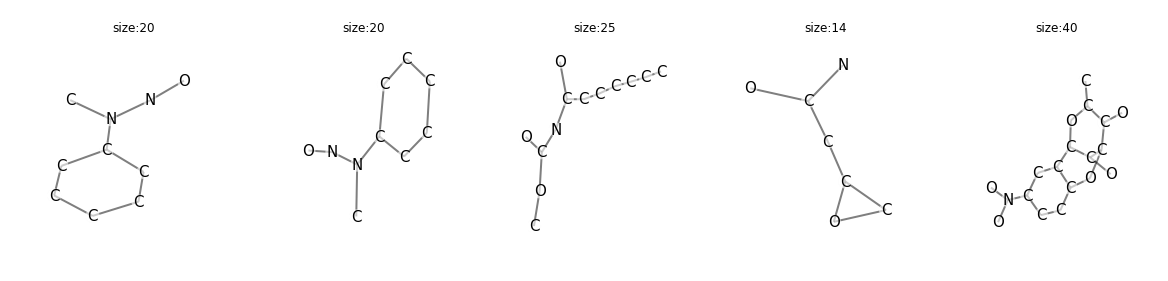

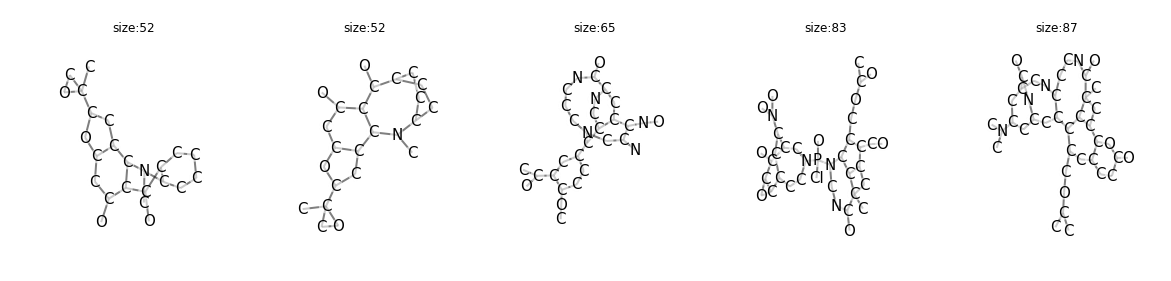

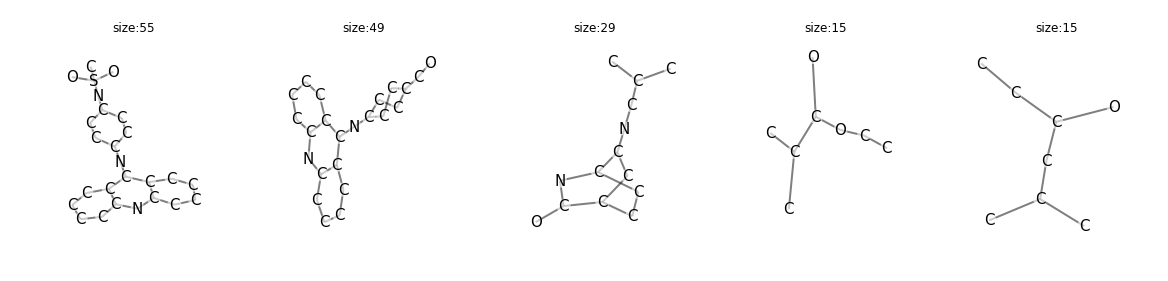

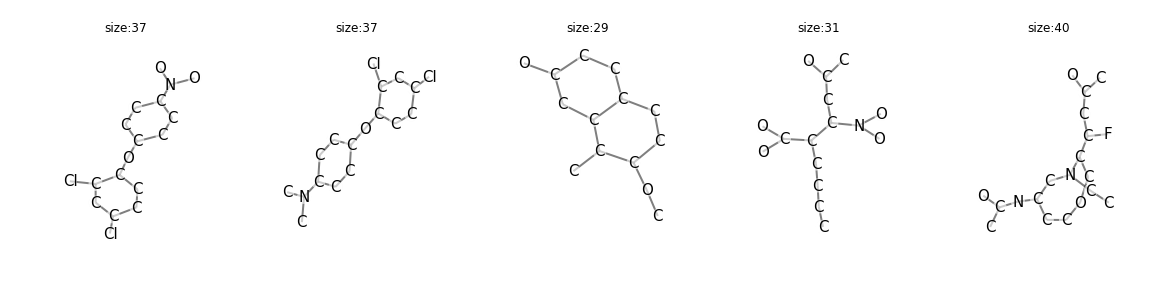

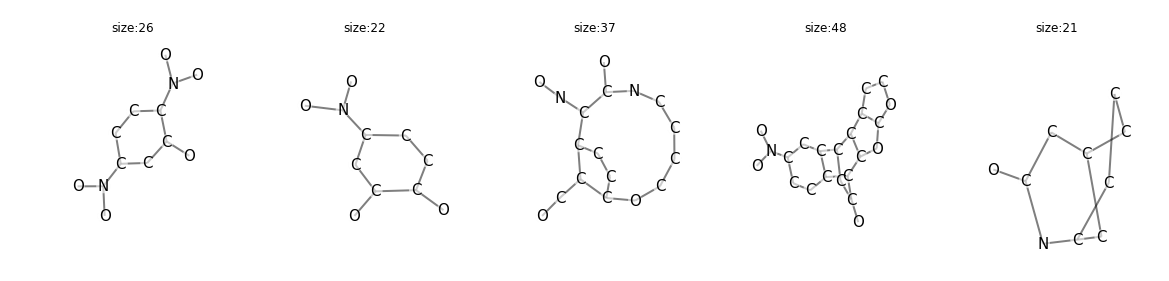

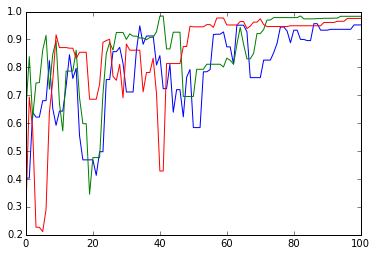

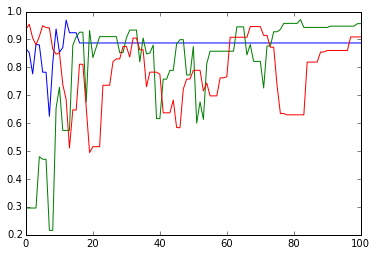

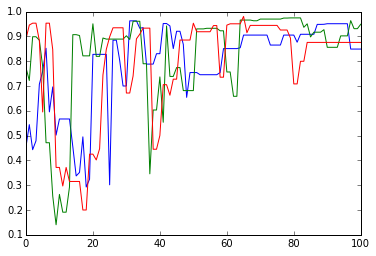

CPU times: user 57.8 s, sys: 2.03 s, total: 59.8 s
Wall time: 1min 11s


In [16]:
%%time
'''
now lets see if we can improve graphs
'''
import sys
sys.path.append('..')
import os
os.nice(19)
%matplotlib inline
import graphlearn.utils.draw as myutils
import graphlearn.graphlearn as gl
from eden.converter.graph.gspan import gspan_to_eden
import itertools
import matplotlib.pyplot as plt


steps=100


sampler=gl.GraphLearnSampler()
sampler.load('tmp/demo.ge')
print "loading done"
graphs = gspan_to_eden( 'bursi.pos.gspan' )
graphs = itertools.islice(graphs,9)
graphs = sampler.sample(graphs,
                        same_radius=False,
                        same_core_size=False,
                        sampling_interval=int(steps/3)+1,
                        batch_size=1,
                        n_steps=steps,
                        n_jobs=1,
                        annealing_factor=0.9)

history=[]

for  i, (result,info) in enumerate(graphs):
    history.append(info['log_score_history'])
    myutils.draw_many_graphs(info['graphs'])
    
    
t = range(steps+1) 
for h in history[:3]:
    plt.plot(t, h)
plt.show()
t = range(steps+1) 
for h in history[3:6]:
    plt.plot(t, h)
plt.show()
t = range(steps+1) 
for h in history[6:]:
    plt.plot(t, h)
plt.show()

#myutils.draw_grammar_stats(sampler.local_substitutable_graph_grammar.grammar)


In [15]:
'''
inform me when done !
'''
import os
os.system("( speaker-test -t sine -f 2000 )& pid=$! ; sleep 1.0s ; kill -9 $pid")

0

In [ ]:
'''
demonstration of discussed thing :) 
'''

import networkx as nx

g=nx.Graph()
g.attrib= 5

h=g.copy()
print 'attrib' in g.__dict__

f=nx.Graph(g)
print 'attrib' in f.__dict__



g=nx.Graph()
g.add_path(["0","1"])
g.attrib=4
f=nx.Graph()
f.add_path(["0","1"])
G = nx.union(f,g , rename=('', '-'))
print 'attrib' in G.__dict__

In [ ]:
'''
HERE WE SEE WHY I USE SHUFFLE INSTEAD OF RANDOMCHOICE::: in the select_cips_from_grammar function...
-> pick at random as long as list of used indeces not as long as list?
-> leave it at the shuffeling?
'''
import random
%%time
x= range(1000000,0,-1)
for e in xrange(100):
    i=x.index(random.choice(x)) 
    x.remove(i)


In [ ]:
%%time
x= range(1000000,0,-1)
random.shuffle(x)
for e in xrange(100):
    i=x.pop() 


In [1]:
# here we see if g.zonk = g.graph['zonk']
import networkx as nx
G=nx.Graph()
G.zing=0
'zing' in G.graph


False

In [8]:
'''
DEMONSTRATION OF THE MANAGER UGLINESS
'''

from multiprocessing import Process, Manager
import joblib
def f(d, l):
    d[1] = '1'
    d['2'] = 2
    d[0.25] = None
    l.reverse()

    
def getmdict():
    manager = Manager()
    return manager.dict(),manager.list(range(10)),manager

    
if __name__ == '__main__':
    
    d,l,manager=getmdict()
    
    p = Process(target=f, args=(d, l))
    p.start()
    p.join()
    
    
    joblib.dump(d,'TEST',compress=1)
    joblib.dump(manager,'TESTMANAGER',compress=1)
    print d
    
    

AttributeError: type object 'SyncManager' has no attribute 'from_address'

In [7]:


d2,l=getmdict()
manager=joblib.load("TESTMANAGER")
d=joblib.load("TEST")
p = Process(target=f, args=(d, l))
p.start()
p.join()

print d
    

<DictProxy object, typeid 'dict' at 0x7f55966cfa10; '__str__()' failed>


Process Process-16:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-7-931045e68831>", line 4, in f
    d[1] = '1'
  File "<string>", line 2, in __setitem__
  File "/usr/lib/python2.7/multiprocessing/managers.py", line 755, in _callmethod
    self._connect()
  File "/usr/lib/python2.7/multiprocessing/managers.py", line 742, in _connect
    conn = self._Client(self._token.address, authkey=self._authkey)
  File "/usr/lib/python2.7/multiprocessing/connection.py", line 169, in Client
    c = SocketClient(address)
  File "/usr/lib/python2.7/multiprocessing/connection.py", line 304, in SocketClient
    s.connect(address)
  File "/usr/lib/python2.7/socket.py", line 224, in meth
    return getattr(self._sock,name)(*args)
error: [Errno 2] No such file or directory


In [9]:

class thing:
    def __init__(self):
        self.data=3

d={}
d[3]={}
d[3][2]=thing()

d[3][2].data



3

In [10]:
import dill


s=dill.dumps(lambda x:x)

f=dill.loads(s)

f(3)



3

In [2]:
def app(l):
    l+=[4,5,6]
    
    
l=[]
app(l)
print l

[4, 5, 6]


In [4]:
try:
    import matplotlib.pyplot as plt
except:
    raise
import networkx as nx


G=nx.cycle_graph(24)
pos=nx.spring_layout(G,iterations=200)
nx.draw(G,pos,node_color=range(8),node_size=800,cmap=plt.cm.Blues)

plt.show() # display


ValueError: Color array must be two-dimensional

In [11]:
from multiprocessing import Manager
m=Manager()
d=m.dict()
dir(d)
di={}
type(d)==dict

False

[]

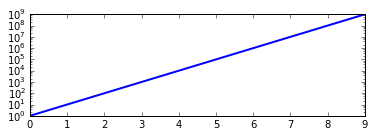

In [3]:
from matplotlib import pyplot

a = [    pow(10,i) for i in range(10)    ]

pyplot.subplot(2,1,1)
pyplot.plot(a, color='blue', lw=2)
pyplot.yscale('log')
pyplot.show()

In [4]:
4 / 5

0

In [3]:
import itertools


def grouper(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
    return itertools.izip_longest(fillvalue=fillvalue, *args)

s="12313141342134234"
[batch for batch in grouper(s,3)]




[('1', '2', '3'),
 ('1', '3', '1'),
 ('4', '1', '3'),
 ('4', '2', '1'),
 ('3', '4', '2'),
 ('3', '4', None)]

In [3]:
for i , s in enumerate("asdasd"):
    print s

a
s
d
a
s
d


In [4]:
i

5